In [1]:
import numpy as np
import pandas as pd
import json
import re
import copy
import pickle
from collections import Counter
import collections
from nltk.stem import WordNetLemmatizer
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
from fuzzywuzzy import fuzz
from ipywidgets import interact
import itertools
import random

![](https://www.kaggle.com/content/v/9da25a3f126b/kaggle/img/site-logo.png)
Recipe Data Downloaded from What's Cooking Competition from Kaggle.com: https://www.kaggle.com/c/whats-cooking
![](https://kaggle2.blob.core.windows.net/competitions/kaggle/4526/media/Yummly_logo.png)
For this, we will be using both data from train.json and test.json. A data_combined list is created to hold all the json objects used as input.

For this project, I will be exploring the what's cooking competition dataset. In it a large assortment of recipie lists with cuisine names packing into neat jsons. The majority of the data cleaning will be done to get files into needed DataFrames, and into formats that allow for more ingredient exploration.

In [2]:
data_combined = []

f = open('/data/BobbyDobo/test.json') 
data = json.load(f)
[data_combined.append(x) for x in data]
f.close()

f = open('/data/BobbyDobo/train.json')
data2 = json.load(f)
[data_combined.append(x) for x in data2]
f.close()

df = pd.read_json('/data/BobbyDobo/test.json')
df2 = pd.read_json('/data/BobbyDobo/train.json')

## Data Cleaning
We will be looking at the data provided by Yummly. As we can see, the data has features of recipe_id, cuisine, and ingredients.

### Original Data

In [3]:
data

[{'id': 18009,
  'ingredients': ['baking powder',
   'eggs',
   'all-purpose flour',
   'raisins',
   'milk',
   'white sugar']},
 {'id': 28583,
  'ingredients': ['sugar',
   'egg yolks',
   'corn starch',
   'cream of tartar',
   'bananas',
   'vanilla wafers',
   'milk',
   'vanilla extract',
   'toasted pecans',
   'egg whites',
   'light rum']},
 {'id': 41580,
  'ingredients': ['sausage links',
   'fennel bulb',
   'fronds',
   'olive oil',
   'cuban peppers',
   'onions']},
 {'id': 29752,
  'ingredients': ['meat cuts',
   'file powder',
   'smoked sausage',
   'okra',
   'shrimp',
   'andouille sausage',
   'water',
   'paprika',
   'hot sauce',
   'garlic cloves',
   'browning',
   'lump crab meat',
   'vegetable oil',
   'all-purpose flour',
   'freshly ground pepper',
   'flat leaf parsley',
   'boneless chicken skinless thigh',
   'dried thyme',
   'white rice',
   'yellow onion',
   'ham']},
 {'id': 35687,
  'ingredients': ['ground black pepper',
   'salt',
   'sausage casing

Let's move that recipe data into a dataframe so that it's easier to explore! I will display and merge the two different datasets I have. Notice that the two input files differ in whether they contain cuisine information.

In [4]:
print(df.count())
df.head(5)

id             9944
ingredients    9944
dtype: int64


id                                        ingredients
0  18009  [baking powder, eggs, all-purpose flour, raisi...
1  28583  [sugar, egg yolks, corn starch, cream of tarta...
2  41580  [sausage links, fennel bulb, fronds, olive oil...
3  29752  [meat cuts, file powder, smoked sausage, okra,...
4  35687  [ground black pepper, salt, sausage casings, l...

In [5]:
print(df2.count())
df2.head(5)

cuisine        39774
id             39774
ingredients    39774
dtype: int64


cuisine     id                                        ingredients
0        greek  10259  [romaine lettuce, black olives, grape tomatoes...
1  southern_us  25693  [plain flour, ground pepper, salt, tomatoes, g...
2     filipino  20130  [eggs, pepper, salt, mayonaise, cooking oil, g...
3       indian  22213                [water, vegetable oil, wheat, salt]
4       indian  13162  [black pepper, shallots, cornflour, cayenne pe...

In [6]:
df_merged = df.append(df2)
print(df_merged.count())
df_merged.head(3).append(df_merged.tail(3))

cuisine        39774
id             49718
ingredients    49718
dtype: int64


cuisine     id                                        ingredients
0          NaN  18009  [baking powder, eggs, all-purpose flour, raisi...
1          NaN  28583  [sugar, egg yolks, corn starch, cream of tarta...
2          NaN  41580  [sausage links, fennel bulb, fronds, olive oil...
39771    irish   2238  [eggs, citrus fruit, raisins, sourdough starte...
39772  chinese  41882  [boneless chicken skinless thigh, minced garli...
39773  mexican   2362  [green chile, jalapeno chilies, onions, ground...

In [7]:
assert df_merged['id'].dtype == 'int64'
assert df_merged['ingredients'].dtype == 'object'
assert df_merged['id'].count() == df['id'].count() + df2['id'].count()
assert df_merged['ingredients'].count() == df['ingredients'].count() + df2['ingredients'].count()
assert df_merged['cuisine'].count() == df2['cuisine'].count()
assert df_merged.isnull()['cuisine'].any() == True
assert df_merged.isnull()['id'].any() == False
assert df_merged.isnull()['ingredients'].any() == False

Let's do some exploration on that cuisine data. I wonder if the recipies or ingredients are skewed toward a certain cuisine.

In [8]:
cuisine = df2.groupby('cuisine').count()
cuisine = cuisine.drop('ingredients', 1)
cuisine.columns = ['count']
cuisine = cuisine.sort_values(['count'], ascending=False)

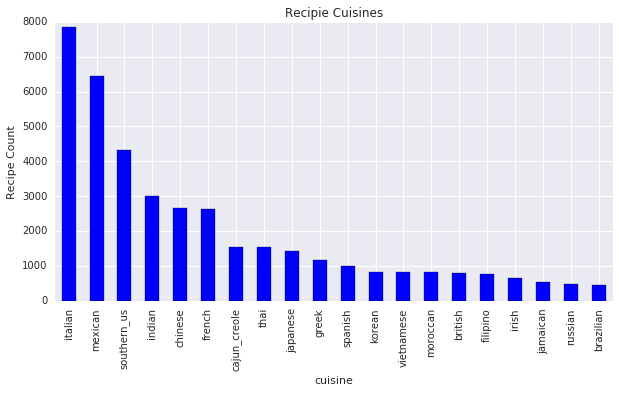

In [9]:
plt.figure(figsize=(10,5));
plt.title("Recipie Cuisines")
plt.ylabel("Recipe Count")
cuisine['count'].plot(kind='bar');

There appears to be a lot of Italian, Mexican, and Southern_US recipies. Just based off the upper cuisines, I'm assuming there will be a lot of use of chicken, pasta, rice, and cheese. Fish probably won't be very high on the list as the island coastal and island cuisines don't rank that high. 

### Flattening the Data
I will be have to clean my data and also flatten the recipies so that I can get data on a per ingredient basis. Unfortunately there are limitations to how I can clean. Learning how to clean similar ingredients such as yogurt and yoghurt would be an entire project in itself!

In [10]:
def json_map(JSON):
    """Returns Flattened recipe Json into a list of (recipe_id, ingredient)

    Keyword arguments:
    JSON -- recipe json with keys, 'id' and 'ingredients'
    """
    lis = []
    for x in JSON:
        id = x['id']
        ingr = x['ingredients']
        for y in ingr:
            lis.append((id,y))
    return lis

def clean_item(item):
    """Cleans and returns a string by lowering, remove odd punctuation, to lemmatizing(unused).

    Keyword arguments:
    item -- string to be cleaned
    """
    item = str.lower(item)
    # http://stackoverflow.com/a/27086669/670873
    def replacing(i):
        i = i.replace('&', '').replace('(', '').replace(')','')
        i = i.replace('\'', '').replace('\\', '').replace(',','')
        i = i.replace('.', '').replace('%', '').replace('/','')
        i = i.replace('"', '')
        return i
    item = replacing(item)  
    return item

In [11]:
test_json = [{'id': 10101010, 'ingredients': ['milk','eggs','bananas']}, {'id': 10101011, 'ingredients': ['milk','cereal']}]
assert clean_item('hello&c') == 'helloc'
assert json_map(test_json) == [(10101010, 'milk'), (10101010, 'eggs'), (10101010, 'bananas'), 
                               (10101011, 'milk'), (10101011, 'cereal')]

### Below is what the data looks like after it is flattened!

In [12]:
flattened = json_map(data_combined)
flattened_clean = [ (entry[0], clean_item(entry[1])) for entry in flattened ]
print("size of data_combined", len(data_combined))
print("size of flattened", len(flattened))
print("size of flattened_cleaned:", len(flattened_clean))
flattened

size of data_combined 49718
size of flattened 535670
size of flattened_cleaned: 535670


[(18009, 'baking powder'),
 (18009, 'eggs'),
 (18009, 'all-purpose flour'),
 (18009, 'raisins'),
 (18009, 'milk'),
 (18009, 'white sugar'),
 (28583, 'sugar'),
 (28583, 'egg yolks'),
 (28583, 'corn starch'),
 (28583, 'cream of tartar'),
 (28583, 'bananas'),
 (28583, 'vanilla wafers'),
 (28583, 'milk'),
 (28583, 'vanilla extract'),
 (28583, 'toasted pecans'),
 (28583, 'egg whites'),
 (28583, 'light rum'),
 (41580, 'sausage links'),
 (41580, 'fennel bulb'),
 (41580, 'fronds'),
 (41580, 'olive oil'),
 (41580, 'cuban peppers'),
 (41580, 'onions'),
 (29752, 'meat cuts'),
 (29752, 'file powder'),
 (29752, 'smoked sausage'),
 (29752, 'okra'),
 (29752, 'shrimp'),
 (29752, 'andouille sausage'),
 (29752, 'water'),
 (29752, 'paprika'),
 (29752, 'hot sauce'),
 (29752, 'garlic cloves'),
 (29752, 'browning'),
 (29752, 'lump crab meat'),
 (29752, 'vegetable oil'),
 (29752, 'all-purpose flour'),
 (29752, 'freshly ground pepper'),
 (29752, 'flat leaf parsley'),
 (29752, 'boneless chicken skinless thigh'

# Building Ingredient Relations
We need to build a food relationship list! This is essential to seeing how often ingredients appear to each other. Unfortunately this process is O(n^2) time.

In [13]:
#https://www.kaggle.com/dipayan/whats-cooking/whatscooking-python/code
temp = df_merged
def relations(df_recipe):
    """Creates a collctions.Counter for each ingredient and returns a list of those.

    Keyword arguments:
    JSON -- recipe json with keys, 'id' and 'ingredients'
    """
    word_relations = {}
    for recipe in df_recipe['ingredients']:
        temp_recipe = copy.deepcopy(recipe)
        for item in recipe:
            temp_recipe.remove(item)
            if item in word_relations:
                word_relations[item].update(temp_recipe)
            else:
                word_relations[item] = Counter(temp_recipe)
            temp_recipe.append(item)
    return word_relations

#This contains all the relations between foods
ingredient_relations = relations(temp)

### Ingredient Relations
Below are food reltionships, there are some pretty intersting food names, and on quick inspection, we notice that there are some ingredients that should be considered the same.

In [14]:
ingredient_relations

{'rice vermicelli': Counter({'Boston lettuce': 1,
          'Heinz Tomato Ketchup': 1,
          'Italian basil': 1,
          'Japanese turnips': 3,
          'Sriracha': 9,
          'Thai fish sauce': 2,
          'Thai red curry paste': 2,
          'Vietnamese coriander': 2,
          'almond butter': 2,
          'anise powder': 1,
          'arrowroot powder': 1,
          'asian basil': 1,
          'asian eggplants': 2,
          'asian fish sauce': 5,
          'avocado': 3,
          'baby bok choy': 1,
          'baby spinach': 1,
          'bacon': 1,
          'baking powder': 1,
          'balm': 3,
          'bamboo shoots': 1,
          'banh trang': 1,
          'basil': 7,
          'basil leaves': 8,
          'baton': 1,
          'bawang goreng': 4,
          'beans': 1,
          'beansprouts': 43,
          'beef': 4,
          'beef broth': 3,
          'beef fillet': 1,
          'beef rib short': 1,
          'beef steak': 1,
          'beef tenderloin': 1,
 

In [15]:
test_relations = relations(temp.head(1))
test_relations2 = relations(temp.head(5))
assert sum(test_relations['all-purpose flour'].values()) == 5
assert sum(test_relations2['all-purpose flour'].values()) == 25
test_json = [{'id': 10101010, 'ingredients': ['milk', 'eggs', 'bananas', 'flour']}, 
             {'id': 10101011, 'ingredients': ['milk','cereal', 'bananas']}]
df_test_json = pd.DataFrame(test_json)
test_json_relations = relations(df_test_json)
assert test_json_relations == {'bananas': Counter({'cereal': 1, 'eggs': 1, 'flour': 1, 'milk': 2}),
 'cereal': Counter({'bananas': 1, 'milk': 1}),
 'eggs': Counter({'bananas': 1, 'flour': 1, 'milk': 1}),
 'flour': Counter({'bananas': 1, 'eggs': 1, 'milk': 1}),
 'milk': Counter({'bananas': 2, 'cereal': 1, 'eggs': 1, 'flour': 1})}

In [16]:
flattened_rec_item = flattened_clean
pickle.dump(data_combined, open('/data/BobbyDobo/data_combined.p', 'wb'))
pickle.dump(flattened_rec_item, open('/data/BobbyDobo/flattened_rec_item.p', 'wb'))
pickle.dump(ingredient_relations, open('/data/BobbyDobo/ingredient_relations.p', 'wb'))